In [ ]:
!pip install tensorflow

import numpy as np
import random
import tensorflow as tf
import os

from PIL import Image, ImageOps
from numpy import asarray

from sklearn.datasets import fetch_lfw_people

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import backend as K

epochs = 10

In [3]:
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def create_pairs(x, digit_indices, classes):
  pairs = []
  labels = []
  
  n=min([len(digit_indices[d]) for d in range(len(classes))]) -1
  
  for d in range(len(classes)):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, len(classes))
      dn = (d + inc) % len(classes)
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)


def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(16, (5,5), activation = 'tanh')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(32, (5,5), activation = 'tanh')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  
  return model

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
# https://drive.google.com/file/d/1FUYIAPJIleHE1uuGMoVXfLSsdKYxHulJ/view?usp=sharing
# https://drive.google.com/file/d/1eckgl4WHptQJ-JmTF-GZLx2YpTvgWLj1/view?usp=sharing
# https://drive.google.com/file/d/1FUYIAPJIleHE1uuGMoVXfLSsdKYxHulJ/view?usp=sharing
# 1sVhlLY158StFC9SW0iz7J2TWTM8wfi5l
# https://drive.google.com/file/d/1eckgl4WHptQJ-JmTF-GZLx2YpTvgWLj1/view?usp=sharing

In [4]:
!gdown 'https://drive.google.com/uc?id=1eckgl4WHptQJ-JmTF-GZLx2YpTvgWLj1'

Downloading...
From: https://drive.google.com/uc?id=1eckgl4WHptQJ-JmTF-GZLx2YpTvgWLj1
To: /content/datacoba2.zip
100% 1.12M/1.12M [00:00<00:00, 104MB/s]


In [ ]:
!unzip /content/datacoba2.zip

In [6]:
# Import data
import os
import numpy

train_dirs = os.listdir("/content/datacoba2/train")
test_dirs = os.listdir("/content/datacoba2/test")

px = 64

x_train = []
for dir in train_dirs:
  img = Image.open(os.path.join("/content/datacoba2/train", dir))
  img = ImageOps.grayscale(img)
  img = img.resize((px, px), Image.ANTIALIAS)
  img = asarray(img)
  x_train.append(img)
x_train = asarray(x_train, dtype = "uint8")

y_train = []
for dir in train_dirs:
  num = dir.split("_")
  y_train.append(num[0])
y_train = asarray(y_train, dtype = "uint8")

x_test = []
for dir in test_dirs:
  img = Image.open(os.path.join("/content/datacoba2/test", dir))
  img = ImageOps.grayscale(img)
  img = img.resize((px, px), Image.ANTIALIAS)
  img = asarray(img)
  x_test.append(img)
x_test = asarray(x_test, dtype = "uint8")

y_test = []
for dir in test_dirs:
  num = dir.split("_")
  y_test.append(num[0])
y_test = asarray(y_test, dtype = "uint8")

In [7]:
train_classes = list(np.unique(y_train) - 1)
test_classes = list(np.unique(y_test) - 1)
print(len(train_classes), len(test_classes))

10 10


In [8]:
x_train = x_train.reshape(x_train.shape[0], px, px, 1)
x_test = x_test.reshape(x_test.shape[0], px, px, 1)
# input_shape = (1, px, px)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
input_shape = (px, px, 1)

(20, 64, 64, 1)


In [9]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i+1)[0] for i in train_classes]
tr_pairs, tr_y = create_pairs(x_train, digit_indices, train_classes)

digit_indices = [np.where(y_test == i+1)[0] for i in test_classes]
te_pairs, te_y = create_pairs(x_test, digit_indices, test_classes)

# network definition
base_network = create_base_net(input_shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 16)        416       
                                                                 
 average_pooling2d (AverageP  (None, 30, 30, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        12832     
                                                                 
 average_pooling2d_1 (Averag  (None, 13, 13, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 5408)              0     

In [10]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [11]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          epochs = 10,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 0.3234 - accuracy: 0.5000 - val_loss: 0.2330 - val_accuracy: 0.8000
Epoch 2/10
1/1 [==============================] - 0s 36ms/step - loss: 0.1941 - accuracy: 0.6500 - val_loss: 0.2549 - val_accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 0s 31ms/step - loss: 0.1630 - accuracy: 0.7000 - val_loss: 0.2423 - val_accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 0s 30ms/step - loss: 0.0948 - accuracy: 0.9000 - val_loss: 0.1774 - val_accuracy: 0.7000
Epoch 5/10
1/1 [==============================] - 0s 31ms/step - loss: 0.0682 - accuracy: 0.9500 - val_loss: 0.2037 - val_accuracy: 0.8500
Epoch 6/10
1/1 [==============================] - 0s 29ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.1671 - val_accuracy: 0.8000
Epoch 7/10
1/1 [==============================] - 0s 30ms/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.1688 - val_accuracy: 0.9000
Epoch 8/10
1/1 [===========

In [13]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 100.00%
* Accuracy on test set: 85.00%


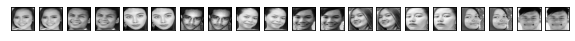

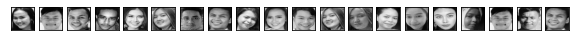

[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]


In [43]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 20
import tensorflow as tf

# print(tr_pairs[1,0].shape)
# tr_pairs[1,0] = tr_pairs[1,0].reshape(28, 28)

y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])

im = tf.keras.preprocessing.image.array_to_img(
    te_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( tr_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

import numpy as np
pred_i = []
pred = []
for i in range(number_of_items):
  pred.append(y_pred[i])
pred = np.array(pred).round().reshape(10, 2).tolist()
for i in range(10):
  print(pred[i])
  
# plt.figure(figsize=(20, 2))
# plt.imshow(im, cmap="gray")
# plt.show()

In [14]:
from google.colab import files
pic = files.upload()

Saving 1_3.jpg to 1_3.jpg


In [15]:
pic = Image.open("/content/1_3.jpg")
pic = ImageOps.grayscale(pic)
pic = pic.resize((px, px), Image.ANTIALIAS)
pic = asarray(pic, dtype = "uint8")

In [16]:
pic = pic.reshape(px, px, 1)
pic = pic.astype('float32')
pic /= 255

In [17]:
pairs = []
for i in range(len(x_train)):
  pairs += [[pic, x_train[i]]]
pairs = np.array(pairs)

In [18]:
y_pred = model.predict([pairs[:, 0], pairs[:, 1]])

In [25]:
ranking = y_pred[:,0].argsort()

In [26]:
idx = [np.where(ranking == i+1)[0] for i in range(3)]

In [30]:
for item in idx:
  print(item[0])

14
5
10


In [39]:
import matplotlib.pyplot as plt

The picture is:


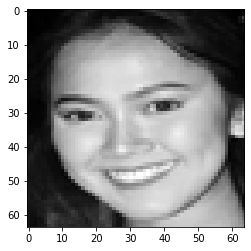

In [40]:
print("The picture is:")
im = tf.keras.preprocessing.image.array_to_img(pic, data_format=None, scale=True,dtype=None)
plt.imshow(im, cmap="gray")

Top 3 most similar picture are:


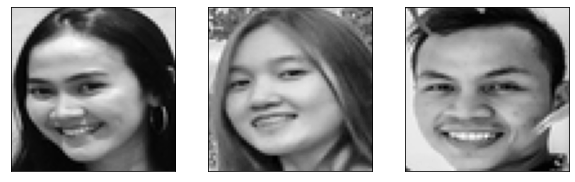

In [41]:
print("Top 3 most similar picture are:")
plt.figure(figsize=(10, 5))
i = 1
for item in idx:
    display = plt.subplot(1, 3, i)
    im = tf.keras.preprocessing.image.array_to_img(pairs[item[0],1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
    i += 1
plt.show()